In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd

In [30]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [37]:
first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x246f27d7198>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [38]:
for row in session.query(Measurement).order_by(Measurement.date.desc()).limit(5).all():
    print(row)

# Exploratory Climate Analysis

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).all()
last_date = dt.datetime.strptime(last_date[0][0], '%Y-%m-%d').date()
print(last_date)

# #Last Date is 2017-08-23

first_date=last_date - dt.timedelta(days=365)
print(first_date)




2017-08-23
2016-08-23


In [58]:
# Perform a query to retrieve the data and precipitation scores
rain_data=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=first_date).\
    order_by(Measurement.date).all()


In [59]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df=pd.DataFrame(rain_data, columns=['Date', 'Precipitation'])
rain_df.set_index('Date').head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [60]:
# Sort the dataframe by date
sorted_rain_df=rain_df.sort_values(by='Date')
sorted_rain_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


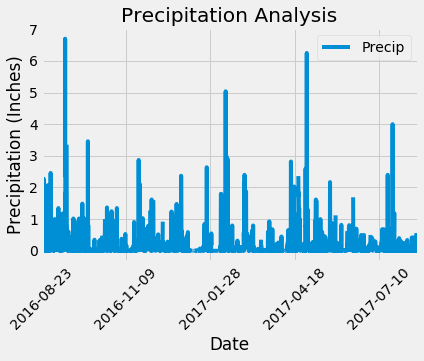

In [61]:
sorted_rain_df.plot('Date', 'Precipitation')
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation Analysis")
plt.legend(["Precip"])
plt.savefig("Images/Precip.png")
plt.show()

In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_stats=sorted_rain_df.describe()
rain_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [63]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement).group_by(Measurement.station).count()
station_count


9

In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active=active_stations[0][0]

stats = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),]

temp_stats=session.query(*stats).filter(Measurement.station==most_active).all()
temp_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

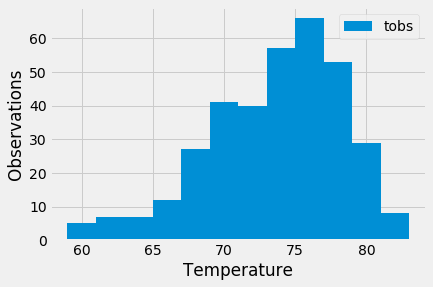

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_active).\
filter(Measurement.date>=first_date).\
order_by(Measurement.date).all()



tobs_df = pd.DataFrame(tobs_data, columns= ["date","tobs"])
tobs_df.plot.hist(bins=12)
plt.xticks(np.arange(60, 85, 5))
plt.yticks(np.arange(0, 70, 10))
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.savefig("Images/tobs.png")
plt.show()

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Trip Dates 8/1/19-8/14/19...use 2017 data for previous year's dates

trip_temps=calc_temps('2017-08-01', '2017-08-14')
print(trip_temps)


[(71.0, 79.01785714285714, 84.0)]


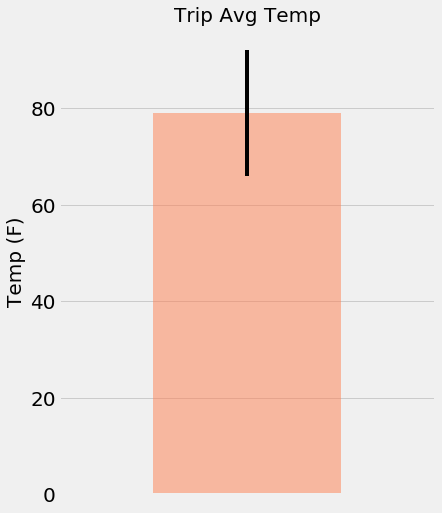

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
temp_delta= trip_df['Max Temp'] - trip_df['Min Temp']
avg_temp.plot(kind='bar', yerr=temp_delta, figsize=(6,8), alpha=.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)", fontsize=20)
plt.xticks([])
plt.yticks(fontsize=20)
plt.savefig("Images/trip_temps")
plt.show()


In [70]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rain=session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2017-08-01', '2017-08-14')).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()

trip_rain_df=pd.DataFrame(trip_rain, columns=['Station', 'Station Name', 'Latitude', 'Longitude', 'Precipitation'])
trip_rain_df

,Station,Station Name,Latitude,Longitude,Precipitation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,0.12
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.02
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,0.00
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,0.00
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,NaN


## Optional Challenge Assignment

In [71]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [72]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]

# Set the start and end date of the trip
# Trip Dates 8/1/19-8/14/19.
# Use the start and end date to create a range of dates
trip_dates = pd.date_range('2017-08-01', '2017-08-14', freq='D')

# Stip off the year and save a list of %m-%d strings
month_day = trip_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date

for date in month_day:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0)]

In [73]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df=pd.DataFrame(normals, index=trip_dates, columns=['tmin', 'tavg', 'tmax'])
trip_normals_df.index.name='date'
trip_normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0


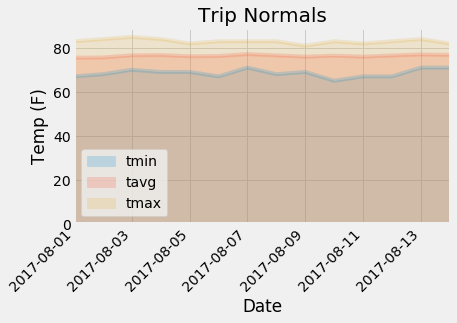

In [74]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot(kind='area',x_compat=True, alpha=.2, stacked=False)
plt.xticks(rotation=45)
plt.title("Trip Normals", fontsize=20)
plt.ylabel("Temp (F)")
plt.xlabel("Date")
plt.savefig("Images/trip_normals")
plt.show()